In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import  stats
import statsmodels.api as sm  # 统计相关的库
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

###  处理原始数据 

In [2]:
sp500=pd.read_excel('C:/apache/jupyter/data.xlsx', sheet_name= "Sheet1",header=0,index_col=0) #read data 

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98
...,...
2012-08-06,1394.23
2012-08-07,1401.35
2012-08-08,1402.22


<AxesSubplot:title={'center':'SP500 Daily Price'}, xlabel='Date'>

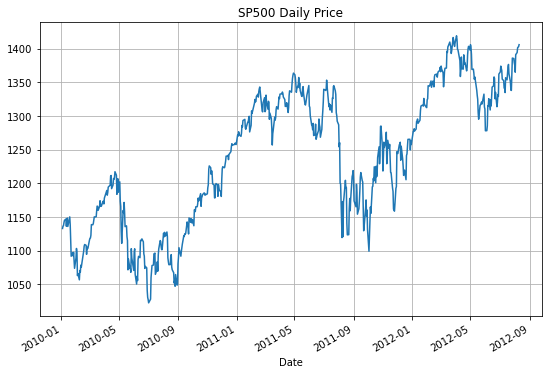

In [5]:
sp500['Price'].plot(figsize=(9,6),title= 'SP500 Daily Price',grid=True)

In [6]:
sp500['r']=np.log(sp500['Price']/sp500['Price'].shift(1))

In [7]:
sp500=sp500.dropna()

In [8]:
sp500.columns = ['Price','r']

In [9]:
sp500.info

<bound method DataFrame.info of               Price         r
Date                         
2010-01-05  1136.52  0.003111
2010-01-06  1137.14  0.000545
2010-01-07  1141.69  0.003993
2010-01-08  1144.98  0.002878
2010-01-11  1146.98  0.001745
...             ...       ...
2012-08-06  1394.23  0.002327
2012-08-07  1401.35  0.005094
2012-08-08  1402.22  0.000621
2012-08-09  1402.80  0.000414
2012-08-10  1405.87  0.002186

[657 rows x 2 columns]>

<AxesSubplot:title={'center':'Daily Log Return'}, xlabel='Date'>

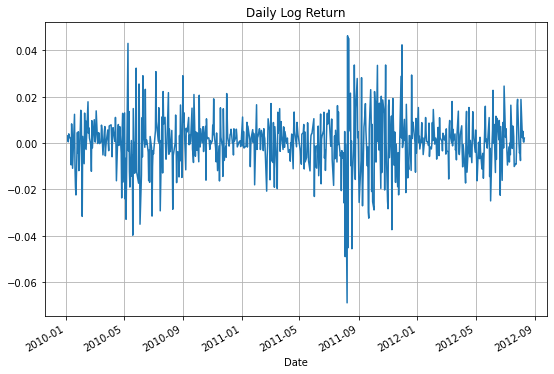

In [10]:
sp500['r'].plot(figsize=(9,6),title= 'Daily Log Return',grid=True)

###  QQ-plot，平稳性检验，LB TEST，JB TEST

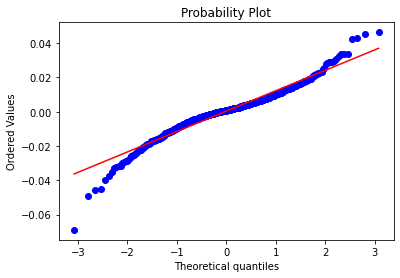

In [11]:
stats.probplot(sp500['r'], dist="norm", plot=plt) #QQ图显示，对数收益率分布存在尖峰厚尾
plt.show()

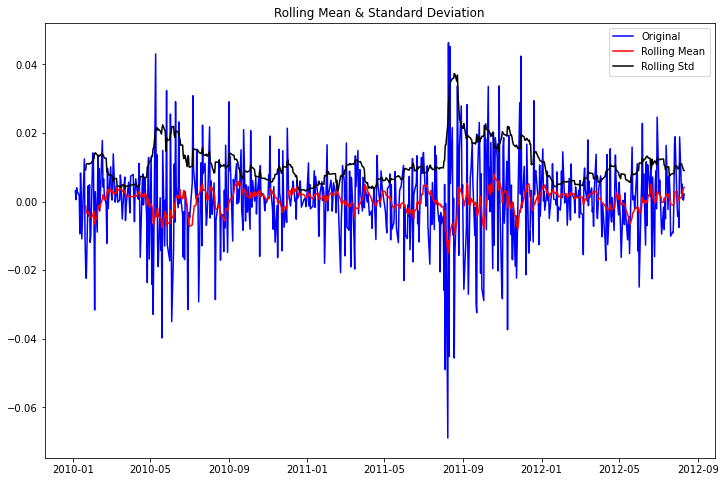

Results of Dickey-Fuller Test:
Test Statistic                -1.314843e+01
p-value                        1.382849e-24
#Lags Used                     4.000000e+00
Number of Observations Used    6.520000e+02
Critical Value (1%)           -3.440419e+00
Critical Value (5%)           -2.865983e+00
Critical Value (10%)          -2.569136e+00
dtype: float64


In [12]:
#平稳性检验
#The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.
#If the pvalue is above a critical size, then we cannot reject that there is a unit root.
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(sp500['r']) #结果显示Pvalue分别小于各个Critical Value，拒绝原假设，对数收益率序列为平稳序列

In [13]:
#混成检验
m = 25 

acf,q,p = sm.tsa.acf(sp500['r'],nlags=m,qstat=True,fft=False)  ## 计算自相关系数，LB test 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output #p-value均小于显著性水平0.05。拒绝原假设H0，即日收益率序列有显著的相关性

,AC,Q,P-value
lag,,,
1.0,-0.078670,4.084709,0.043273
2.0,0.067766,7.120196,0.028436
3.0,-0.104959,14.413252,0.002393
4.0,0.041822,15.572966,0.003649
5.0,-0.131330,27.026203,0.000056
6.0,0.004433,27.039270,0.000142
7.0,0.003433,27.047121,0.000327
8.0,-0.018615,27.278293,0.000633
9.0,-0.015164,27.431943,0.001186


In [14]:
#JB TEST 正态性检验 pvalue<0.05 拒绝原假设，样本不服从正态分布
stats.jarque_bera(sp500['r'])

Jarque_beraResult(statistic=337.2163728717211, pvalue=0.0)

###   均值方程 AR定阶，并检验残差即残差平方的相关性

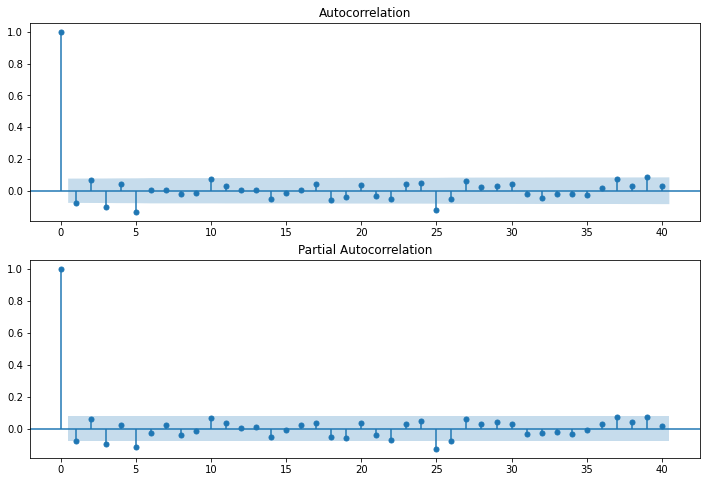

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sp500['r'], lags=40,alpha=0.05, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sp500['r'], lags=40,alpha=0.05,ax=ax2)

In [17]:
#建立AR(5)均值方程
model = ARIMA(sp500.loc[:'2012-01-01','r'], order=(5, 0, 0)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


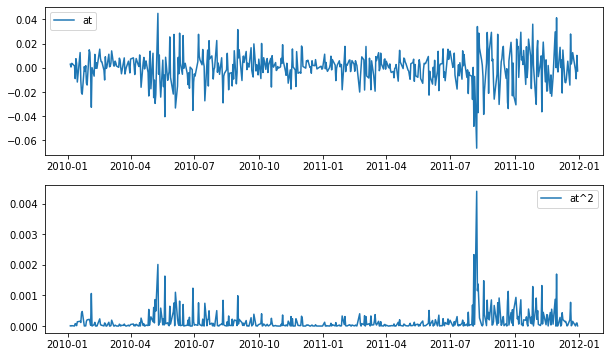

In [18]:
# 计算残差at=rt−mut
#画出残差及残差的平方
at = sp500.loc[:'2012-01-01','r'] -  model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

In [19]:
#对{a2t}序列进行混成检验 ，残差ARCH效应检验
m = 25 # 检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True,fft=False)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output
#LB TEST结果显示，p-value小于显著性水平0.05，拒绝原假设，即认为残差序列at2具有序列相关性。因此具有ARCH效应。

,AC,Q,P-value
lag,,,
1.0,0.095507,4.615540,3.168351e-02
2.0,0.382631,78.846033,7.564872e-18
3.0,0.122607,86.482943,1.246838e-18
4.0,0.200472,106.941137,3.267301e-22
5.0,0.085160,110.640309,3.000355e-22
6.0,0.113658,117.242716,6.179646e-23
7.0,0.086335,121.059993,4.608013e-23
8.0,0.221245,146.178951,1.227445e-27
9.0,0.100144,151.335812,4.663121e-28


### 建立并拟合GARCH（1，1）模型

In [20]:
#建立GARCH模型,因为dta数据偏小，所以调整为 100倍
#为了方便后续计算，均值方程并未采用AR(5)，而是选择了Constant，拟合效果并无显著区别
#使用garch（1，1）模型
am = arch_model(sp500['r']*100,mean='Constant',vol='GARCH',rescale=False ) 

In [21]:
res = am.fit(last_obs="2012-01-01")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2830.3553773819635
Iteration:      2,   Func. Count:     14,   Neg. LLF: 817768.7680288923
Iteration:      3,   Func. Count:     21,   Neg. LLF: 943.786444597655
Iteration:      4,   Func. Count:     29,   Neg. LLF: 779.2530368363732
Iteration:      5,   Func. Count:     35,   Neg. LLF: 884.2828745460163
Iteration:      6,   Func. Count:     42,   Neg. LLF: 778.6154983863298
Iteration:      7,   Func. Count:     47,   Neg. LLF: 778.6154904958407
Iteration:      8,   Func. Count:     51,   Neg. LLF: 778.615490496039
Optimization terminated successfully    (Exit mode 0)
            Current function value: 778.6154904958407
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


In [22]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      r   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -778.615
Distribution:                  Normal   AIC:                           1565.23
Method:            Maximum Likelihood   BIC:                           1582.11
                                        No. Observations:                  503
Date:                Sat, Jun 05 2021   Df Residuals:                      502
Time:                        08:26:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0758  4.312e-02      1.759  7.860e-02 [-8.67

### 得到的波动率模型为  (sigmat)**2 = 0.0344 + 0.1261*(Xt-1)**2 + 0.859*(sigmat-1)**2 

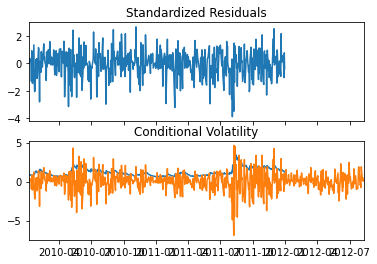

In [23]:
#plot the conditional variance generated by GARCH(1,1)
res.plot()
plt.plot(sp500['r']*100)

In [24]:
res.params

mu          0.075837
omega       0.034444
alpha[1]    0.126098
beta[1]     0.858969
Name: params, dtype: float64

In [57]:
#Forecasting VaR
forecasts = res.forecast(start='2012-01-01', reindex = True )
cond_mean = forecasts.mean["2012":]
cond_var = forecasts.variance["2012":]
test = sp500.loc['2012':,'r']*100
cvar = np.array(cond_var).squeeze()
std_rets = (test - res.params["mu"]) / np.sqrt(cvar)
std_rets

Date
2012-01-03    1.179421
2012-01-04   -0.049086
2012-01-05    0.199052
2012-01-06   -0.317490
2012-01-09    0.152816
                ...   
2012-08-06    0.146366
2012-08-07    0.424266
2012-08-08   -0.014271
2012-08-09   -0.037744
2012-08-10    0.164428
Name: r, Length: 154, dtype: float64

In [58]:
#计算empirical分位数
q_E = std_rets.quantile([0.025, 0.05])
print(q_E)
value_at_risk_E = cond_mean.values + np.sqrt(cond_var).values * q_E.values[None, :]
value_at_risk_E = pd.DataFrame(value_at_risk_E, columns=["2.5%", "5%"], index=cond_var.index)
value_at_risk_E

0.025   -1.704250
0.050   -1.367691
Name: r, dtype: float64


,2.5%,5%
Date,,
2012-01-03,-2.033421,-1.616881
2012-01-04,-1.904758,-1.513627
2012-01-05,-1.791511,-1.422744
2012-01-06,-1.694786,-1.345120
2012-01-09,-1.597856,-1.267332
...,...,...
2012-08-06,-1.750136,-1.389540
2012-08-07,-1.665667,-1.321751
2012-08-08,-1.568919,-1.244109


In [59]:
#计算Parametric VaR
value_at_risk_G_25 = cond_mean.values + np.sqrt(cond_var).values * (-1.96)
value_at_risk_G_50 = cond_mean.values + np.sqrt(cond_var).values * (-1.64)
value_at_risk_G = np.hstack([value_at_risk_G_25,value_at_risk_G_50])
value_at_risk_G = pd.DataFrame(value_at_risk_G, columns=["2.5%", "5%"], index=cond_var.index)
value_at_risk_G

,2.5%,5%
Date,,
2012-01-03,-2.349949,-1.953902
2012-01-04,-2.201979,-1.830091
2012-01-05,-2.071737,-1.721113
2012-01-06,-1.960497,-1.628034
2012-01-09,-1.849021,-1.534758
...,...,...
2012-08-06,-2.024153,-1.681298
2012-08-07,-1.927007,-1.600012
2012-08-08,-1.815741,-1.506912


## 展示SP500 2012年实际对数收益分布，基于实际分布的VaR线（绿色2.5%，蓝色5%），基于garch预测的VaR线（红色2.5%，黄色5%）

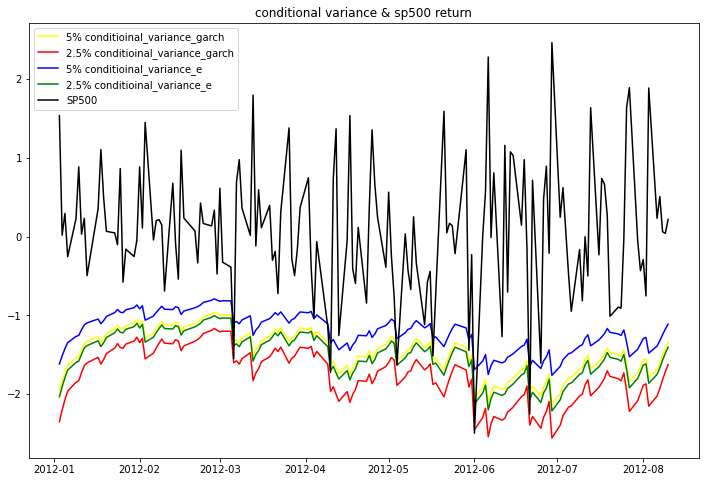

In [60]:
#展示SP500 2012年实际对数收益分布，基于实际分布的VaR线（绿色2.5%，蓝色5%），基于garch预测的VaR线（红色2.5%，黄色5%）
fig = plt.figure(figsize=(12, 8))
VaR50_GARCH = plt.plot(value_at_risk_G['5%'], color='yellow', label='5% conditioinal_variance_garch')
VaR25_GARCH = plt.plot(value_at_risk_G['2.5%'], color='red', label='2.5% conditioinal_variance_garch')
VaR50_E = plt.plot(value_at_risk_E['5%'], color='blue', label='5% conditioinal_variance_e')  
VaR25_E = plt.plot(value_at_risk_E['2.5%'], color='green', label='2.5% conditioinal_variance_e')
rsp500 = plt.plot(sp500.loc['2012-01-01':,'r']*100, color='black', label = 'SP500')
plt.legend(loc='best')
plt.title('conditional variance & sp500 return')
plt.show()
#基于garch的线更向外，基于实际分布的更向内，基于GARCH的预测波动更大
#对于不同的分布，VaR2.5%的线比VaR5%的线更向外，与实际效果一致

In [64]:
-value_at_risk_G['5%'].mean()

1.4579779988419528

In [65]:
-value_at_risk_E['5%'].mean()

1.2033005897549995